In [62]:
import pandas as pd
import numpy as np
import os
import copy
import itertools
from operator import itemgetter
import plotly.express as px

import sys

sys.path.append(os.path.abspath(os.path.join("../.."))) 
from source.train_test_split import split_data



Load Data

In [63]:
def load_all_simulated_logs(base_simulation_dir):
    """
    Load all simulated log CSVs from a given base directory into a single DataFrame.
    
    Parameters:
        base_simulation_dir (str): Path to the directory containing simulated_log_*.csv files.
    
    Returns:
        pd.DataFrame: A combined DataFrame of all simulated logs, with a 'simulation_run' column.
    """
    simulated_logs = []
    for root, dirs, files in os.walk(base_simulation_dir):
        for file in files:
            if file.startswith("simulated_log_") and file.endswith(".csv"):
                simulated_logs.append(os.path.join(root, file))

    simulated_log_dfs = []
    for log_path in simulated_logs:
        df = pd.read_csv(log_path)
        simulation_index = int(os.path.basename(log_path).split('_')[-1].split('.')[0])
        df["simulation_run"] = simulation_index
        simulated_log_dfs.append(df)

    if simulated_log_dfs:
        return pd.concat(simulated_log_dfs, ignore_index=True)
    else:
        raise FileNotFoundError(f"No simulated logs found in {base_simulation_dir}")



In [64]:
raw_df_train, raw_df_test, num_cases_to_simulate = split_data("../../raw_data/LoanApp.csv.gz", 
                                                        {
                                                            "case_id": "case_id", 
                                                            "activity_name": "activity",
                                                            "resource_name": "resource",
                                                            "end_time": "end_timestamp",
                                                            "start_time": "start_timestamp"
                                                            },
                                                        None
                                                        )


The train log conisists of 797 cases
The test log conisists of 200 cases


In [117]:
simulated_logs_df = load_all_simulated_logs("../../simulated_data/LoanApp.csv/main_results/")
simulated_logs_df = simulated_logs_df.rename(columns={'activity_name': 'activity'})
# simulated_logs_df = load_all_simulated_logs("../../simulated_data/LoanApp.csv/autonomous/")

Circle Time Calculation

In [98]:
def calculate_cycle_time(df, start_column, end_column):
    temp = df.copy()
    try:
        temp['start_time'] = pd.to_datetime(df[start_column])
    except:
        temp['start_time'] = pd.to_datetime(df[start_column], utc=True, format="mixed")
    try:
        temp['end_time'] = pd.to_datetime(df[end_column])
    except:
        temp['end_time'] = pd.to_datetime(df[end_column], utc=True, format="mixed")

    grouped = temp.groupby('case_id').agg(start=('start_time', 'min'), end=('end_time', 'max'))
    grouped['cycle_time'] = (grouped['end'] - grouped['start']).dt.total_seconds()/60 # minites
    return grouped

In [99]:
raw_logs_cycle_times = calculate_cycle_time(raw_df_test, 'start_timestamp', 'end_timestamp').reset_index()
# raw_logs_cycle_times = raw_df_test.merge(raw_logs_cycle_times.reset_index()).drop_duplicates(subset='case_id', keep='first')
simulated_logs_cycle_times = calculate_cycle_time(simulated_logs_df, 'start_timestamp', 'end_timestamp').reset_index()
# simulated_logs_cycle_times = simulated_logs_df.merge(simulated_logs_cycle_times.reset_index())

In [100]:
simulated_logs_cycle_times

,case_id,start,end,cycle_time
0,0,2023-04-20 08:00:00+00:00,2023-04-20 12:10:01.063148979+00:00,250.017719
1,1,2023-04-20 08:30:00+00:00,2023-04-20 13:43:22.096051463+00:00,313.368268
2,2,2023-04-20 09:00:00+00:00,2023-04-20 12:21:25.923659805+00:00,201.432061
3,3,2023-04-20 09:30:00+00:00,2023-04-20 14:02:47.334061884+00:00,272.788901
4,4,2023-04-20 10:00:00+00:00,2023-04-20 12:34:28.303846782+00:00,154.471731
...,...,...,...,...
195,195,2023-05-08 09:30:00+00:00,2023-05-08 14:47:30.544967068+00:00,317.509083
196,196,2023-05-08 10:00:00+00:00,2023-05-09 07:40:41.970868449+00:00,1300.699514
197,197,2023-05-08 10:30:00+00:00,2023-05-09 08:16:28.558184950+00:00,1306.475970
198,198,2023-05-08 11:00:00+00:00,2023-05-08 14:59:54.398954666+00:00,239.906649


In [101]:
raw_logs_cycle_times

,case_id,start,end,cycle_time
0,800,2023-04-20 08:00:00,2023-04-20 10:00:00.265,120.004417
1,801,2023-04-20 08:30:00,2023-04-20 11:57:19.826,207.330433
2,802,2023-04-20 09:00:00,2023-04-20 13:23:18.894,263.314900
3,803,2023-04-20 09:30:00,2023-04-20 11:04:47.091,94.784850
4,804,2023-04-20 10:00:00,2023-04-20 13:26:49.419,206.823650
...,...,...,...,...
195,995,2023-05-08 09:30:00,2023-05-08 10:41:48.529,71.808817
196,996,2023-05-08 10:00:00,2023-05-08 11:02:40.519,62.675317
197,997,2023-05-08 10:30:00,2023-05-08 13:07:09.378,157.156300
198,998,2023-05-08 11:00:00,2023-05-08 12:12:48.215,72.803583


Circle Time Distribution Histograms

In [102]:
raw_times = raw_logs_cycle_times['cycle_time']
sim_times = simulated_logs_cycle_times['cycle_time']

# Shared bin edges
max_time = max(raw_times.max(), sim_times.max())
bin_edges = np.arange(0, max_time + 20, 20)

# Bin and count
raw_bins = pd.cut(raw_times, bins=bin_edges)
sim_bins = pd.cut(sim_times, bins=bin_edges)

raw_counts = raw_bins.value_counts().sort_index()
sim_counts = sim_bins.value_counts().sort_index()

# Bin labels
bin_labels = [f"{int(interval.left)}-{int(interval.right)} min" for interval in raw_counts.index]

# Build long-format DataFrame for grouped bars
df_raw = pd.DataFrame({
    "Cycle Time Bin": bin_labels,
    "Number of Cases": raw_counts.values,
    "Type": "Raw"
})

df_sim = pd.DataFrame({
    "Cycle Time Bin": bin_labels,
    "Number of Cases": sim_counts.values,
    "Type": "Simulated"
})

combined_df = pd.concat([df_raw, df_sim], ignore_index=True)

# Plot grouped vertical bars
fig = px.bar(combined_df,
             x="Cycle Time Bin",
             y="Number of Cases",
             color="Type",
             barmode="group",
             title="Comparison of Raw vs Simulated Cycle Time Distributions")

fig.update_layout(xaxis_title="Cycle Time (Minutes)", yaxis_title="Number of Cases", height=700)
fig.show()


In [103]:
raw_logs_cycle_times[['case_id', 'cycle_time']].describe()

,case_id,cycle_time
count,200.000000,200.000000
mean,899.500000,667.278783
std,57.879185,1042.410255
min,800.000000,45.125017
25%,849.750000,104.211967
50%,899.500000,156.245383
75%,949.250000,1101.242067
max,999.000000,4082.978850


In [104]:
simulated_logs_cycle_times.describe()

,case_id,cycle_time
count,200.000000,200.000000
mean,99.500000,1337.407959
std,57.879185,1246.567160
min,0.000000,154.471731
25%,49.750000,301.830407
50%,99.500000,1233.453911
75%,149.250000,1417.599856
max,199.000000,4306.685183


We see that comparing the original simulator logs and the raw logs the distribution of the cycle time is the similar (slightly shofted to the right) but the actual mean and median is too skewed. This makes sense if we consider that the original agents can conduct actions concurently while the simulated ones only one at a time

In [108]:
simulated_logs_df[simulated_logs_df['case_id']==1]

,case_id,agent,activity_name,start_timestamp,end_timestamp,TimeStep,resource,simulation_run
2,1,1,Check application form completeness,2023-04-20 08:30:00+00:00,2023-04-20 09:47:59.629677030+00:00,2,Clerk-000002,8
5,1,6,Appraise property,2023-04-20 09:47:59.629677030+00:00,2023-04-20 09:57:21.627302392+00:00,5,Appraiser-000002,8
9,1,9,Check credit history,2023-04-20 09:57:21.627302392+00:00,2023-04-20 11:37:52.675070524+00:00,9,Clerk-000006,8
15,1,2,AML check,2023-04-20 11:37:52.675070524+00:00,2023-04-20 12:16:35.896546521+00:00,15,AML Investigator-000001,8
21,1,16,Assess loan risk,2023-04-20 12:16:35.896546521+00:00,2023-04-20 12:36:35.896546521+00:00,21,Loan Officer-000004,8
...,...,...,...,...,...,...,...,...
13538,1,10,Check credit history,2023-04-20 08:42:04.261173922+00:00,2023-04-20 09:53:14.364257103+00:00,3,Clerk-000007,0
13543,1,2,AML check,2023-04-20 09:53:14.364257103+00:00,2023-04-20 10:28:08.647016887+00:00,8,AML Investigator-000001,0
13546,1,6,Appraise property,2023-04-20 10:28:08.647016887+00:00,2023-04-20 10:34:26.605728399+00:00,11,Appraiser-000002,0
13551,1,13,Assess loan risk,2023-04-20 10:34:26.605728399+00:00,2023-04-20 10:54:26.605728399+00:00,16,Loan Officer-000002,0


We also notice that the number of activities in a case is way larger in the simulated log

In [119]:
def activities_per_case_distribution(df, label):
    return (
        df.groupby("case_id")["activity"]
        .nunique()
        .reset_index(name="num_activities")
        .assign(Type=label)
    )

# Compute distribution
df_raw_acts = activities_per_case_distribution(raw_df_test, "Raw")
df_sim_acts = activities_per_case_distribution(simulated_logs_df, "Simulated")

# Combine
df_acts = pd.concat([df_raw_acts, df_sim_acts], ignore_index=True)

# Plot
fig = px.histogram(
    df_acts,
    x="num_activities",
    color="Type",
    barmode="overlay",  # use "group" for side-by-side
    nbins=20,
    title="Distribution of Number of Unique Activities per Case",
    labels={"num_activities": "Unique Activities in Case", "count": "Number of Cases"}
)

fig.update_layout(
    bargap=0.2,
    template="plotly_white",
    legend_title="Log Type"
)

fig.show()


This raises questions about the correctless of the outputed traces. I'm using a function I made for my optimizer to check. It is checking for correct endings, pre and post conditions

In [124]:
def validate_simulated_log(df, prerequisites, post_conditions, valid_end_activities, case_col='case_id', activity_col='activity', order_by='start_timestamp'):
    issues = []

    for case_id, group in df.groupby(case_col):
        sorted_activities = group.sort_values(by=order_by)[activity_col].tolist()

        if not sorted_activities:
            issues.append((case_id, "Empty trace"))
            continue

        # Remove zzz_end for logic checks
        activities_no_end = [a for a in sorted_activities if a != "zzz_end"]

        # 🚨 1. Prerequisites check
        performed = set()
        for act in activities_no_end:
            required = prerequisites.get(act, [])
            if not all(pre in performed for pre in required):
                missing = [pre for pre in required if pre not in performed]
                issues.append((case_id, f"Activity '{act}' missing prerequisites {missing}"))
            performed.add(act)

        # 🚨 2. Post-conditions check
        for i, act in enumerate(activities_no_end):
            required_posts = post_conditions.get(act, [])
            future_acts = set(activities_no_end[i+1:])  # only activities after current one
            for post in required_posts:
                if post not in future_acts:
                    issues.append((case_id, f"Activity '{act}' missing required post-condition '{post}'"))

        # 🚨 3. End correctness check
        if activities_no_end:
            last_real_activity = activities_no_end[-1]
            if last_real_activity not in valid_end_activities:
                issues.append((case_id, f"Case ends incorrectly on '{last_real_activity}'"))

    return issues

# discovered from my mining
prereqs = {
    'Check application form completeness': [],
    'Check credit history': ['Check application form completeness'],
    'AML check': ['Check application form completeness'],
    'Appraise property': ['Check application form completeness'],
    'Assess loan risk': ['Appraise property',
    'AML check',
    'Check credit history'],
    'Design loan offer': ['Assess loan risk'],
    'Approve loan offer': ['Design loan offer'],
    'Cancel application': ['Approve loan offer'],
    'Approve application': ['Approve loan offer'],
    'Reject application': ['Assess loan risk'],
    'Return application back to applicant': ['Check application form completeness'],
    'Applicant completes form': ['Return application back to applicant']
    }

post_conditions = {
    'Check application form completeness': ['Appraise property',
    'AML check',
    'Check credit history'],
    'Check credit history': ['Assess loan risk'],
    'AML check': ['Assess loan risk'],
    'Appraise property': ['Assess loan risk'],
    'Design loan offer': ['Approve loan offer'],
    'Return application back to applicant': ['Applicant completes form'],
    'Applicant completes form': ['Check application form completeness']
    }

valid_ends = {'Approve application', 'Cancel application', 'Reject application'}


In [125]:
issues = validate_simulated_log(simulated_logs_df, prereqs, post_conditions, valid_ends)
if not issues:
    print("✅ All simulated cases passed validation!")
else:
    print(f"❌ Found {len(issues)} problems:")
    for case_id, problem in issues:
        print(f"Case {case_id}: {problem}")


❌ Found 9 problems:
Case 5: Activity 'Check application form completeness' missing required post-condition 'Appraise property'
Case 5: Activity 'Check application form completeness' missing required post-condition 'AML check'
Case 5: Activity 'Check application form completeness' missing required post-condition 'Appraise property'
Case 5: Activity 'Check application form completeness' missing required post-condition 'AML check'
Case 5: Activity 'Applicant completes form' missing required post-condition 'Check application form completeness'
Case 152: Activity 'Check application form completeness' missing required post-condition 'Appraise property'
Case 152: Activity 'Check application form completeness' missing required post-condition 'Appraise property'
Case 152: Activity 'Check application form completeness' missing required post-condition 'Appraise property'
Case 152: Activity 'Applicant completes form' missing required post-condition 'Check application form completeness'


We see that some post conditions are not respected. Other than that the system is correct. Of course only for this dataset. Other more complex datasets with complex post conditions will not be able to be handled properly by the system

In [136]:
def plot_avg_duration_per_activity(df_raw, df_simulated, time_unit="seconds"):
    """
    Compare average duration per activity between raw and simulated logs.

    Parameters:
    - df_raw: DataFrame with 'activity', 'start_timestamp', 'end_timestamp' columns
    - df_simulated: Same as df_raw, simulated log
    - time_unit: 'seconds', 'minutes', or 'hours' for duration units

    Returns:
    - Plotly figure
    """
    unit_divisor = {
        "seconds": 1,
        "minutes": 60,
        "hours": 3600
    }.get(time_unit, 1)

    def compute_avg(df, label):
        df = df.copy()
        # Auto-detect correct column names
        start_col = "start" if "start" in df.columns else "start_timestamp"
        end_col = "end" if "end" in df.columns else "end_timestamp"

        df[start_col] = pd.to_datetime(df[start_col], format="mixed")
        df[end_col] = pd.to_datetime(df[end_col], format="mixed")
        
        return (
            df[df["activity"] != "zzz_end"]
            .assign(duration=(df["end_timestamp"] - df["start_timestamp"]).dt.total_seconds() / unit_divisor)
            .groupby("activity")["duration"]
            .mean()
            .reset_index()
            .assign(Type=label)
        )

    avg_raw = compute_avg(df_raw, "Raw")
    avg_sim = compute_avg(df_simulated, "Simulated")
    df_avg = pd.concat([avg_raw, avg_sim], ignore_index=True)

    fig = px.bar(
        df_avg,
        x="activity",
        y="duration",
        color="Type",
        barmode="group",
        title=f"Average Activity Duration ({time_unit.title()}): Raw vs Simulated",
        labels={"duration": f"Avg Duration ({time_unit})", "activity": "Activity"}
    )

    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

In [137]:
plot_avg_duration_per_activity(raw_df_test, simulated_logs_df, time_unit="minutes")

Here we see something suspicious. The simulated durations are way way shorter (their average) compared to the ground truth.

In [147]:

raw_df_test['start_timestamp'] = pd.to_datetime(raw_df_test['start_timestamp'])
raw_df_test['end_timestamp'] = pd.to_datetime(raw_df_test['end_timestamp'])
raw_df_test['duration_minutes'] = (raw_df_test['end_timestamp'] - raw_df_test['start_timestamp']).dt.total_seconds() / 60

fig = px.histogram(raw_df_test,
                   x='duration_minutes',
                   facet_col='activity',
                   facet_col_wrap=2,
                   nbins=200,
                   title="Activity Duration Distributions (Raw Logs)",
                   labels={'duration_minutes': 'Duration (minutes)'},
                   color_discrete_sequence=['indianred'])

fig.update_layout(height=800)
fig.show()


Load data

In [100]:
raw_logs = pd.read_csv("../../raw_data/LoanApp.csv.gz", compression='gzip')
# simulated_logs = pd.read_csv("../../simulated_data/LoanApp.csv/main_results/simulated_log_0.csv")
simulated_logs = pd.read_csv("../../simulated_data/LoanApp.csv/main_results/simulated_log_1.csv")
my_logs = pd.read_csv("naive_simulator_logs.csv")

# First, randomly sample 200 unique case_ids
sampled_case_ids = raw_logs['case_id'].drop_duplicates().sample(n=200, random_state=42)

In [101]:
# Then, filter the dataset to only include rows with those case_ids
sampled_raw_logs = raw_logs[raw_logs['case_id'].isin(sampled_case_ids)]

Calculate Circle Time

In [144]:
def calculate_cycle_time(df, start_column, end_column):
    temp = df.copy()
    try:
        temp['start_time'] = pd.to_datetime(df[start_column])
    except:
        temp['start_time'] = pd.to_datetime(df[start_column], utc=True, format="mixed")
    try:
        temp['end_time'] = pd.to_datetime(df[end_column])
    except:
        temp['end_time'] = pd.to_datetime(df[end_column], utc=True, format="mixed")

    grouped = temp.groupby('case_id').agg(start=('start_time', 'min'), end=('end_time', 'max'))
    grouped['cycle_time'] = (grouped['end'] - grouped['start']).dt.total_seconds()/60 # minites
    return grouped

In [98]:
# temp = my_logs.copy()
# temp['start_time'] = pd.to_datetime(temp['start'], utc=True, format="mixed")
# temp['end_time'] = pd.to_datetime(temp['end'], utc=True, format="mixed")
# grouped = temp.groupby('case_id').agg(start=('start_time', 'min'), end=('end_time', 'max'))
# grouped['cycle_time'] = (grouped['end'] - grouped['start']).dt.total_seconds()/60 # minites
# grouped.reset_index(inplace=True)
# grouped

Compare Average Circle Times

In [103]:
real_cycle_times = calculate_cycle_time(sampled_raw_logs, 'start_time', 'end_time')
simulator_cycle_times = calculate_cycle_time(simulated_logs, 'start_timestamp', 'end_timestamp')
naive_simulator_cycle_times = calculate_cycle_time(my_logs, 'start', 'end')

print(f"Real average cycle time: {real_cycle_times.mean():.2f} minutes")
print(f"Simulated average cycle time: {simulator_cycle_times.mean():.2f} minutes")
print(f"Naively Simulated average cycle time: {naive_simulator_cycle_times.mean():.2f} minutes")

Real average cycle time: 633.71 minutes
Simulated average cycle time: 714.50 minutes
Naively Simulated average cycle time: 520.85 minutes


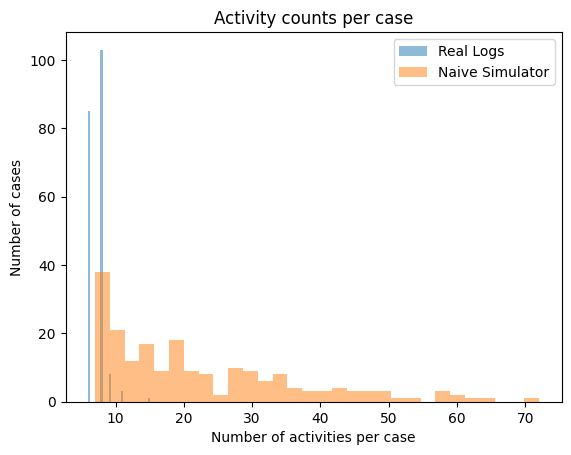

In [105]:
import matplotlib.pyplot as plt

real_counts = sampled_raw_logs.groupby('case_id').size()
naive_counts = my_logs.groupby('case_id').size()

plt.hist(real_counts, bins=30, alpha=0.5, label='Real Logs')
plt.hist(naive_counts, bins=30, alpha=0.5, label='Naive Simulator')
plt.xlabel('Number of activities per case')
plt.ylabel('Number of cases')
plt.legend()
plt.title('Activity counts per case')
plt.show()


In [108]:
simulated_logs[simulated_logs['case_id'] == 0]

,case_id,agent,activity_name,start_timestamp,end_timestamp,TimeStep,resource
0,0,0,Check application form completeness,2023-04-20 08:00:00+00:00,2023-04-20 08:05:36.308585737+00:00,0,Clerk-000001
1,0,1,Check credit history,2023-04-20 08:05:36.308585737+00:00,2023-04-20 09:26:05.375334973+00:00,1,Clerk-000002
3,0,6,Appraise property,2023-04-20 09:26:05.375334973+00:00,2023-04-20 09:26:31.074338936+00:00,3,Appraiser-000002
6,0,2,AML check,2023-04-20 09:26:31.074338936+00:00,2023-04-20 09:36:18.883347487+00:00,6,AML Investigator-000001
8,0,16,Assess loan risk,2023-04-20 09:36:18.883347487+00:00,2023-04-20 09:56:18.883347487+00:00,8,Loan Officer-000004
13,0,0,Reject application,2023-04-20 09:56:18.883347487+00:00,2023-04-20 10:06:18.883347487+00:00,13,Clerk-000001


In [110]:
raw_logs[raw_logs['case_id'] == 10]

,case_id,resource,activity,start_time,end_time
66,10,Clerk-000006,Check application form completeness,2023-02-09T13:00:00.000,2023-02-09T13:08:51.232
67,10,Clerk-000002,Check credit history,2023-02-09T13:08:51.232,2023-02-09T13:12:14.665
73,10,Appraiser-000002,Appraise property,2023-02-09T13:08:51.232,2023-02-09T13:29:47.376
79,10,AML Investigator-000001,AML check,2023-02-09T13:08:51.232,2023-02-09T13:50:42.043
83,10,Loan Officer-000002,Assess loan risk,2023-02-09T13:50:42.043,2023-02-09T14:10:42.043
84,10,Clerk-000002,Reject application,2023-02-09T14:10:42.043,2023-02-09T14:20:42.043
